# An SIA flowline with temperature dependent ice softness

Flow law parameter A is a function of temperature T

$A = A_0 \exp \left( - \frac{Q}{RT} + \frac{3C}{(T_r-T)^k}\right)$

with $A_0 = 9.302\cdot 10^7 \, \text{kPa}^{-3} \text{yr}^{-1}$, $Q = 78.8 \, \text{kJ/mol}$, $R = 8.321 \, \text{J/(mol K)}$, $C = 0.166 \, \text{K}^k$, $T_r = 273.39 \, \text{K}$ and $k = 1.17$ (values vom van der Veen book)

Temperature T is a function of surface elevation $s=b+h$. We assume a lapse rate of $\Gamma = 7 \, \text{K/km}$. In a realistic glacier we have a temperature gradient in the ice. The simple SIA model has no depth resolution, so we have T(x), i.e. A(x)

In [1]:
# Python setup
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

# Catching warnings as errors
import warnings
warnings.filterwarnings("error")

# Making plots nicer
plt.rcParams['figure.figsize'] = 12,8
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['font.size'] = 32
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['font.sans-serif'] = [u"Liberation Sans"] + plt.rcParams['font.sans-serif']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.xmargin'] =  0.1  # x margin.  See `axes.Axes.margins`
plt.rcParams['axes.ymargin'] =  0.1  # y margin See `axes.Axes.margins`
plt.rcParams['image.cmap'] = 'magma'

## Define and plot the temperature dependent flow law parameter

In [158]:
# Flow law parameters
A0 = 9.302e-2 # in Pa^(-3) yr^(-1)
Q = 78.8e3    # activation energy for creep
R = 8.321     # gas constant
C = 0.166
Tr = 273.39
k = 1.17

# Flow law
def AT(T):
    return A0 * np.exp( - Q / (R*T) + (3*C) / np.power(Tr - T,k))

Text(0,0.5,'A [Pa^(-3) yr^(-1)]')

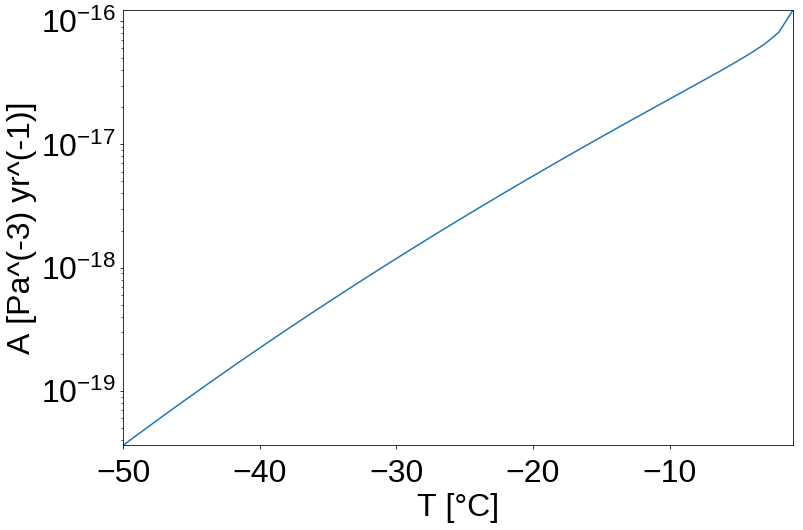

In [14]:
T = np.linspace(Tr-50,Tr-1,49)
A = AT(T)
plt.semilogy(T-Tr,A)
plt.xlim(np.min(T-Tr), np.max(T-Tr))
plt.ylim(np.min(A), np.max(A))
plt.xlabel("T [°C]")
plt.ylabel("A [Pa^(-3) yr^(-1)]")

## Test the influence of temperature (no elevation feedback) 

In [159]:
# Other parameters
#A = 1e-16 # Ice flow parameter
rho = 910 # Ice density
grav = 9.81 # Gravitation constant
n = 3 # Glen index
#a = 0.3 # Surface mass balance

# Model setup
N = 51 # Number of grid points
L = 1.5e6 # Length of domain
time_end = 2e4 # Run time

In [152]:
def solve_implicit(b,L,time_end,dt,a=0.3,T=273):
    N = len(b)
    dx = L/ (N-1) # Grid spacing
    x = np.linspace(0,L,N) # Horizontal distance
    A = AT(T)  # Flow parameter
                    
    # Initializing
    h = np.zeros(N) # Ice thickness
    d = np.zeros(N) # Diffusion coefficients
    alpha = np.zeros(N) 
    beta = np.zeros(N) 
    gamma = np.zeros(N) 
    delta = np.zeros(N) 
    f = np.zeros(N) 
    g = np.zeros(N)
    time_lapse = int(np.round(time_end / dt) +1)
    dtdx = dt / dx**2

    # time stepping
    for i in range(time_lapse):
        slope = np.diff(b+h) / dx # slope on a staggered grid
        # compute diffusion coefficients
        for j in range(N-1): 
            hstag = (h[j+1] + h[j]) /2 # ice thickness on staggered grid
            d[j] = 2/(n+2) * A * hstag**2 *slope[j]**2 * (rho*grav*hstag)**n
        # compute greek parameters
        for j in range(1,N-1):
            alpha[j] = d[j-1] * dtdx
            gamma[j] = d[j] * dtdx
            beta[j] = 1 + gamma[j] + alpha[j]
            delta[j] = h[j] +a * dt + alpha[j] * b[j-1] - (beta[j]-1) * b[j] + gamma[j] * b[j+1]
        # compute f and g
        for j in range(1,N-1):
            f[j] = gamma[j] / (beta[j] - alpha[j] * f[j-1])
            g[j] = ( delta[j] + alpha[j] * g[j-1]) / (beta[j] - alpha[j] * f[j-1])
        # compute ice thickness
        h_new = np.zeros(N)
        for j in range(2,N-1):
            l = N-j
            h_new[l] = g[l] + f[l] * h_new[l+1]
        h = h_new

        #if i%500 == 0:
        #    plt.plot(x,b+h)
    plt.plot(x,b+h, label="T = " + str(T))
    plt.plot(x,b,linewidth=7,color="black")
    plt.xlim(0,L)
    plt.ylim(np.min(b+h),1.1* np.max(b+h))
    plt.legend(loc="lower left")
    plt.tight_layout()

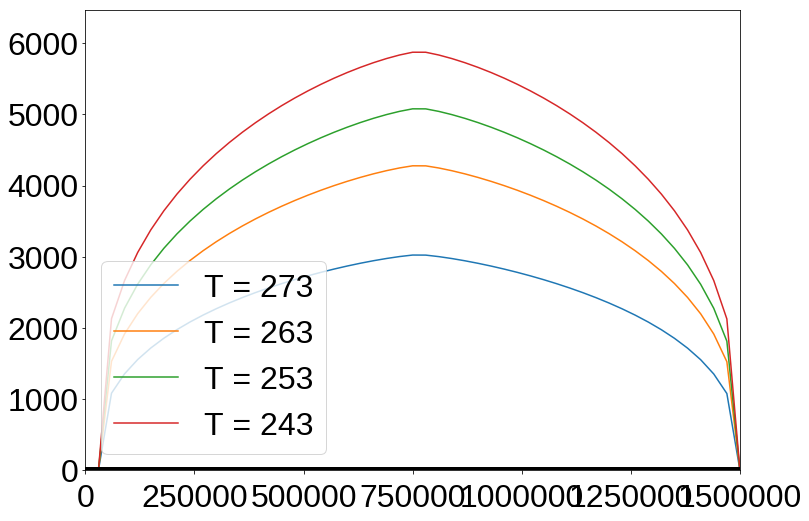

In [36]:
b = np.zeros(N) # Bedrock elevation
dt = 5 # time step
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-10)
solve_implicit(b,L,time_end,dt,T=273-20)
solve_implicit(b,L,time_end,dt,T=273-30)

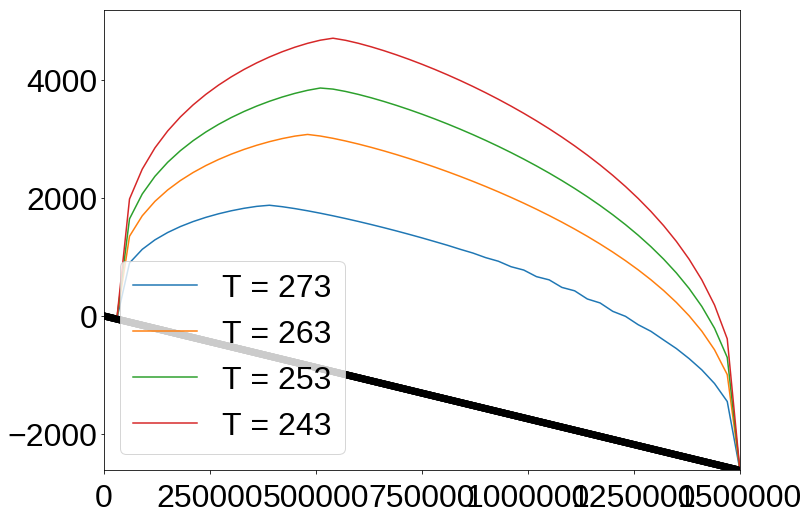

In [37]:
angle = 0.1 # in degree
tan = np.tan(angle*np.pi/180)
x = np.linspace(0,L,N) # Horizontal distance
b = -tan*x
dt = 7 # time step
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-10)
solve_implicit(b,L,time_end,dt,T=273-20)
solve_implicit(b,L,time_end,dt,T=273-30)

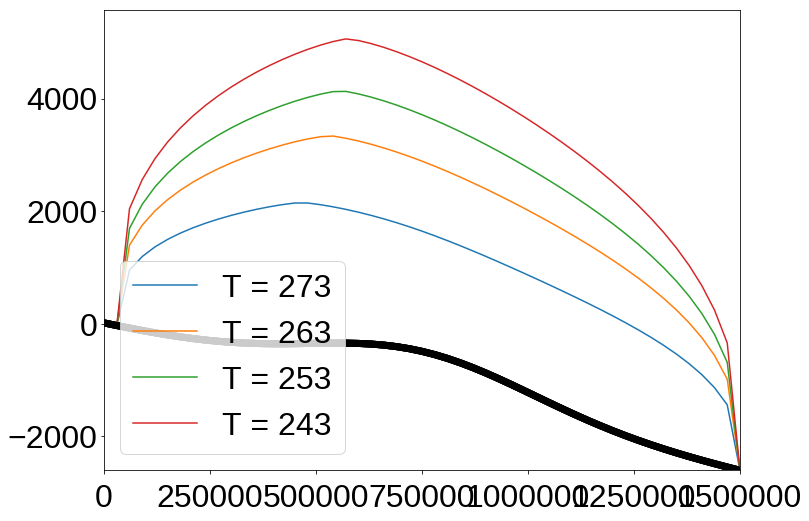

In [38]:
b = -tan*x + np.exp(-(x-L/2)**2/(L/4)**2) / (0.7*tan)
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-10)
solve_implicit(b,L,time_end,dt,T=273-20)
solve_implicit(b,L,time_end,dt,T=273-30)

## Temperature - elevation feedback

In [160]:
Gamma = 8e-3  # in T/m
# Temperature as a funton of surface elevation
def TAlt(s):
    return Tr - 1 - Gamma * s

In [161]:
def solve_implicit2(b,L,time_end,dt,a=0.3):
    N = len(b)
    dx = L/ (N-1) # Grid spacing
    x = np.linspace(0,L,N) # Horizontal distance

                    
    # Initializing
    h = np.zeros(N) # Ice thickness
    d = np.zeros(N) # Diffusion coefficients
    alpha = np.zeros(N) 
    beta = np.zeros(N) 
    gamma = np.zeros(N) 
    delta = np.zeros(N) 
    f = np.zeros(N) 
    g = np.zeros(N)
    time_lapse = int(np.round(time_end / dt) +1)
    dtdx = dt / dx**2
    
    T = TAlt(b+h)
    A = AT(T)  # Flow parameter

    # time stepping
    for i in range(time_lapse):
        T = TAlt(b+h)
        A = AT(T)  # Flow parameter
        slope = np.diff(b+h) / dx # slope on a staggered grid
        # compute diffusion coefficients
        for j in range(N-1): 
            hstag = (h[j+1] + h[j]) /2 # ice thickness on staggered grid
            d[j] = 2/(n+2) * A[j] * hstag**2 *slope[j]**2 * (rho*grav*hstag)**n
        # compute greek parameters
        for j in range(1,N-1):
            alpha[j] = d[j-1] * dtdx
            gamma[j] = d[j] * dtdx
            beta[j] = 1 + gamma[j] + alpha[j]
            delta[j] = h[j] +a * dt + alpha[j] * b[j-1] - (beta[j]-1) * b[j] + gamma[j] * b[j+1]
        # compute f and g
        for j in range(1,N-1):
            f[j] = gamma[j] / (beta[j] - alpha[j] * f[j-1])
            g[j] = ( delta[j] + alpha[j] * g[j-1]) / (beta[j] - alpha[j] * f[j-1])
        # compute ice thickness
        h_new = np.zeros(N)
        for j in range(2,N-1):
            l = N-j
            h_new[l] = g[l] + f[l] * h_new[l+1]
        h = h_new

        #if i%500 == 0:
        #    plt.plot(x,b+h)
    plt.plot(x,b+h, label="with feedback")
    plt.plot(x,b,linewidth=7,color="black")
    plt.xlim(0,L)
    plt.ylim(np.min(b+h),1.1* np.max(b+h))
    plt.legend(loc="lower left")
    plt.tight_layout()

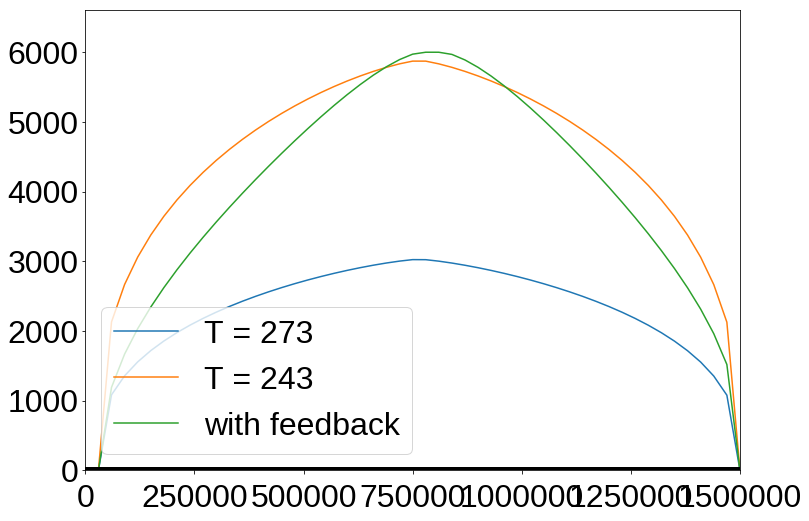

In [167]:
b = np.zeros(N) # Bedrock elevation
dt = 5 # time step
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-30)
solve_implicit2(b,L,time_end,dt)

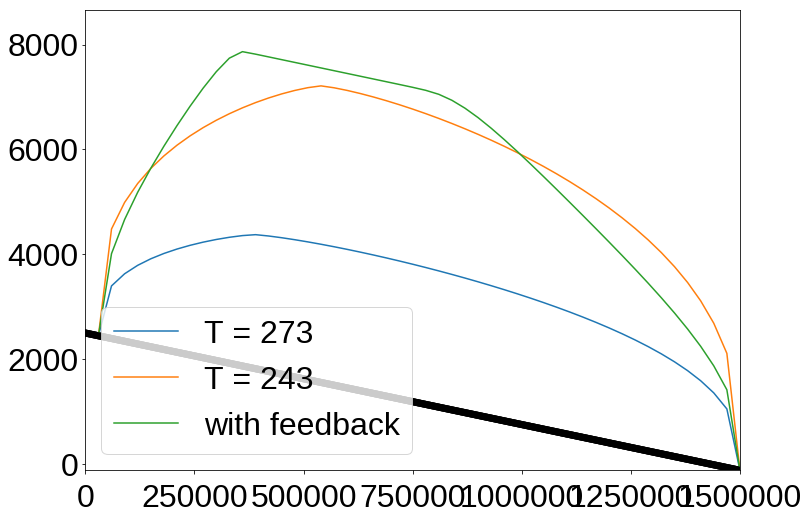

In [168]:
angle = 0.1 # in degree
tan = np.tan(angle*np.pi/180)
x = np.linspace(0,L,N) # Horizontal distance
b = -tan*x + 2500
dt = 5 # time step
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-30)
solve_implicit2(b,L,time_end,dt)

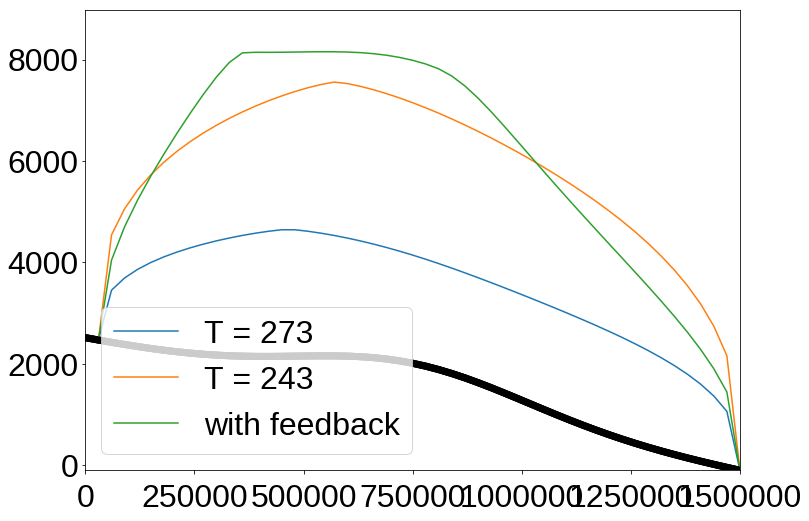

In [169]:
b = -tan*x + np.exp(-(x-L/2)**2/(L/4)**2) / (0.7*tan) + 2500
solve_implicit(b,L,time_end,dt)
solve_implicit(b,L,time_end,dt,T=273-30)
solve_implicit2(b,L,time_end,dt)

The higher the ice sheet is, the colder and stiffer it gets. High points of the ice sheet stay high.

# Temperature - elevation feedback with an elevation dependent surface mass balance
Now mass balance $a$ is a function of surface elevation $s$. The equilibrium altitude $E$ separates melting and precipation.
$$a = (s-E) \cdot e$$

Temperature is now tied to the equilibrium altitude: $T=0°C$ below the equilibrum altitude, $s\leq E$, because we have melting there, and decreases for increasing surface elevation.

In [94]:
def TAlt(s,E):
    Tr = 273.39
    T = Tr - 1 - Gamma * (s - E)
    for i in range(len(T)):
        if T[i] > Tr -1:
            T[i] = Tr-1
    return T

In [138]:
def solve_implicit_mb_T(b,L,time_end,dt,E,e,plot_time=100,h_init=np.zeros(N),plot_E=True,legend=True):
    N = len(b)
    dx = L/ (N-1) # Grid spacing
    x = np.linspace(0,L,N) # Horizontal distance
              
    # Initializing
    h = h_init
    #h = np.zeros(N) # Ice thickness
    d = np.zeros(N) # Diffusion coefficients
    alpha = np.zeros(N) 
    beta = np.zeros(N) 
    gamma = np.zeros(N) 
    delta = np.zeros(N) 
    f = np.zeros(N) 
    g = np.zeros(N)
    time_lapse = int(np.round(time_end / dt) +1)
    dtdx = dt / dx**2


    # time stepping
    for i in range(time_lapse):
        T = TAlt(b+h,E)
        A = AT(T)  # Flow parameter
        slope = np.diff(b+h) / dx # slope on a staggered grid
        # compute diffusion coefficients
        for j in range(N-1): 
            hstag = (h[j+1] + h[j]) /2 # ice thickness on staggered grid
            d[j] = 2/(n+2) * A[j] * hstag**2 *slope[j]**2 * (rho*grav*hstag)**n
        # compute greek parameters
        for j in range(1,N-1):
            # compute mass balance
            a = (b[j]+h[j] - E) * e
            if h[j]<0 and a<0:
                a=0
            alpha[j] = d[j-1] * dtdx
            gamma[j] = d[j] * dtdx
            beta[j] = 1 + gamma[j] + alpha[j]
            delta[j] = h[j] +a * dt + alpha[j] * b[j-1] - (beta[j]-1) * b[j] + gamma[j] * b[j+1]
        # compute f and g
        for j in range(1,N-1):
            f[j] = gamma[j] / (beta[j] - alpha[j] * f[j-1])
            g[j] = ( delta[j] + alpha[j] * g[j-1]) / (beta[j] - alpha[j] * f[j-1])
        # compute ice thickness
        h_new = np.zeros(N)
        for j in range(2,N-1):
            l = N-j
            h_new[l] = g[l] + f[l] * h_new[l+1]
        h = h_new
        
        #if plot_time != 0:
         #   if i%plot_time == 0:
    plt.plot(x,b+h,color="red",linewidth=2, label="with feedback")
    plt.xlim(0,L)
    plt.ylim(np.min(b+h),1.1* np.max(b+h))
    plt.plot(x,b,linewidth=7,color="black")
    if legend:
        plt.legend(loc="upper right")
    if plot_E:
        plt.plot(x,E*np.ones(N),linewidth=5,color="blue")
    return h

In [139]:
def solve_implicit_mb(b,L,time_end,dt,E,e,plot_time=100,h_init=np.zeros(N),plot_E=True,legend=True):
    N = len(b)
    dx = L/ (N-1) # Grid spacing
    x = np.linspace(0,L,N) # Horizontal distance
    A = 1e-16
              
    # Initializing
    h = h_init
    #h = np.zeros(N) # Ice thickness
    d = np.zeros(N) # Diffusion coefficients
    alpha = np.zeros(N) 
    beta = np.zeros(N) 
    gamma = np.zeros(N) 
    delta = np.zeros(N) 
    f = np.zeros(N) 
    g = np.zeros(N)
    time_lapse = int(np.round(time_end / dt) +1)
    dtdx = dt / dx**2

    # time stepping
    for i in range(time_lapse):
        slope = np.diff(b+h) / dx # slope on a staggered grid
        # compute diffusion coefficients
        for j in range(N-1): 
            hstag = (h[j+1] + h[j]) /2 # ice thickness on staggered grid
            d[j] = 2/(n+2) * A * hstag**2 *slope[j]**2 * (rho*grav*hstag)**n
        # compute greek parameters
        for j in range(1,N-1):
            # compute mass balance
            a = (b[j]+h[j] - E) * e
            if h[j]<0 and a<0:
                a=0
            alpha[j] = d[j-1] * dtdx
            gamma[j] = d[j] * dtdx
            beta[j] = 1 + gamma[j] + alpha[j]
            delta[j] = h[j] +a * dt + alpha[j] * b[j-1] - (beta[j]-1) * b[j] + gamma[j] * b[j+1]
        # compute f and g
        for j in range(1,N-1):
            f[j] = gamma[j] / (beta[j] - alpha[j] * f[j-1])
            g[j] = ( delta[j] + alpha[j] * g[j-1]) / (beta[j] - alpha[j] * f[j-1])
        # compute ice thickness
        h_new = np.zeros(N)
        for j in range(2,N-1):
            l = N-j
            h_new[l] = g[l] + f[l] * h_new[l+1]
        h = h_new
        
        #if plot_time != 0:
        #    if i%plot_time == 0:
    plt.plot(x,b+h, color="green",linewidth=2, label="without feedback")
    plt.xlim(0,L)
    #plt.ylim(np.min(b+h),1.1* np.max(b+h))
    plt.plot(x,b,linewidth=7,color="black")
    if legend:
        plt.legend(loc="upper right")
    if plot_E:
        plt.plot(x,E*np.ones(N),linewidth=5,color="blue")
    return h

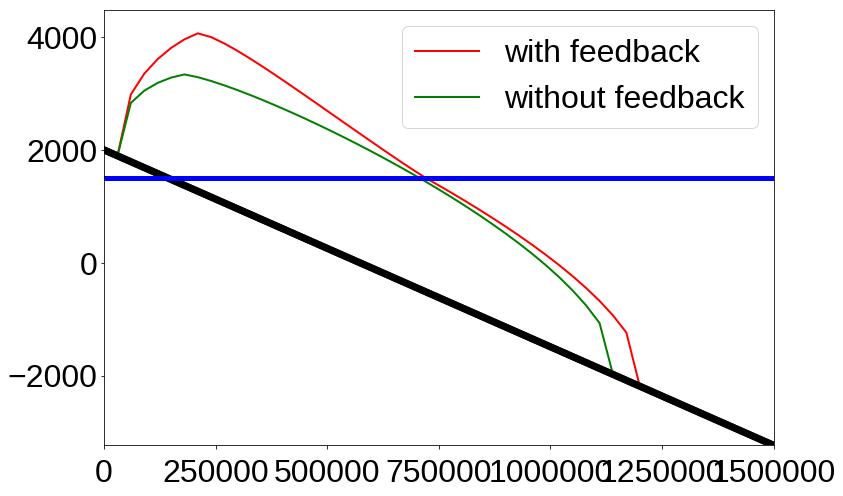

In [140]:
E = 1500
e = 0.3 / 2000
b = -2*tan*x + 2000
dt = 7 # time step
time_end = 15e4 # Run time
h=solve_implicit_mb_T(b,L,time_end,dt,E,e)
h=solve_implicit_mb(b,L,time_end,dt,E,e)

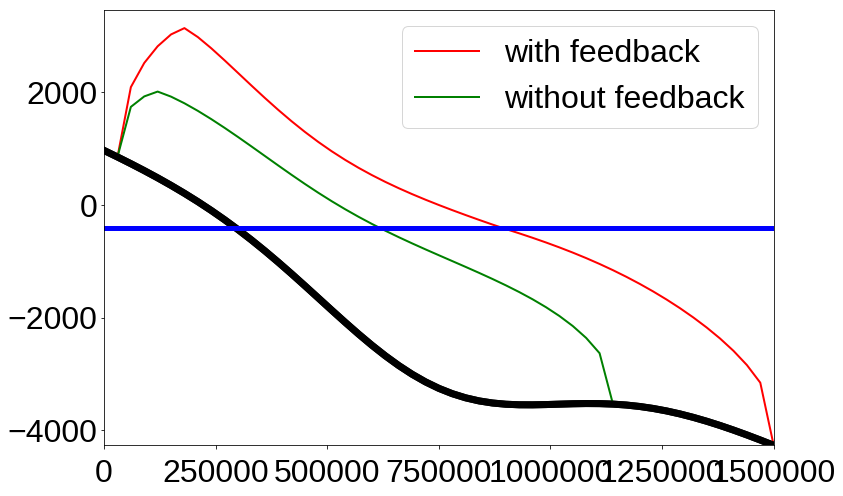

In [124]:
b = -2*tan*x - 2*np.exp(-(x-L/2)**2/(L/4)**2) / (0.7*tan)+ 1000
E = -400
h=solve_implicit_mb_T(b,L,time_end,dt,E,e)
h=solve_implicit_mb(b,L,time_end,dt,E,e)

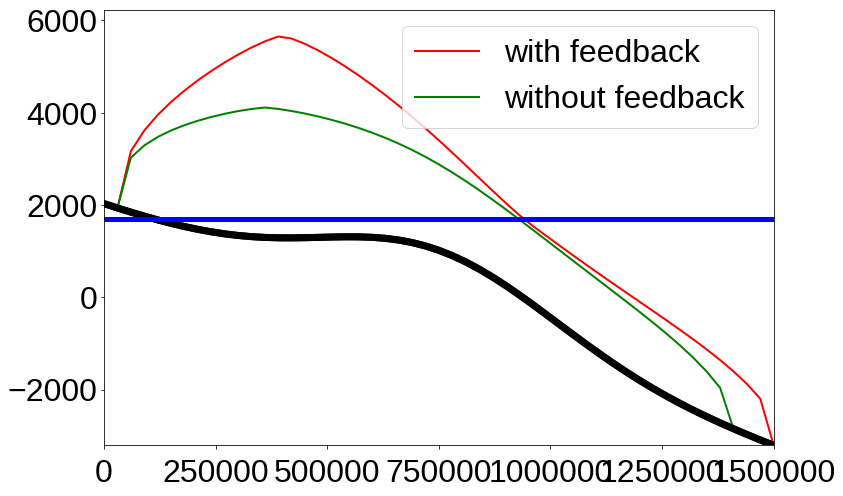

In [125]:
b = -2*tan*x + 2*np.exp(-(x-L/2)**2/(L/4)**2) / (0.7*tan)+ 2000
E = 1700
h=solve_implicit_mb_T(b,L,time_end,dt,E,e)
h=solve_implicit_mb(b,L,time_end,dt,E,e)

The two curves have the same flow parameter below the equilibrium altitude, but above the equilibrium altitude the feedback solution is stiffer and hence builds a larger ice sheet.

## Migrating equilibrium line

In [145]:
b = -2*tan*x - 3*np.exp(-(x-L/2)**2/(L/4)**2) / (0.7*tan)+ 5500
dt = 5 # time step
time_end = 15e4 # Run time
E_list = np.linspace(-300,-1000,15) + 4500
E_list = np.append(E_list,np.flipud(E_list[0:-1]))
print(E_list)
#E_list = np.array([0,-200,-250,-275,-300,-325,-350,-375,-400,-425,-450,-475,-500,-525,-550,-575,-600,-575,-550,-525,-500,-475,-450,-425,-400,-375,-350,-325,-300,-275,-250,-200,0])
l_list = np.zeros(len(E_list))
lT_list = np.zeros(len(E_list))

[ 4200.  4150.  4100.  4050.  4000.  3950.  3900.  3850.  3800.  3750.
  3700.  3650.  3600.  3550.  3500.  3550.  3600.  3650.  3700.  3750.
  3800.  3850.  3900.  3950.  4000.  4050.  4100.  4150.  4200.]


In [146]:
def ice_sheet_size(h):
    N = len(h)
    for i in range(N):
        if h[N-i-1]>1e-5:
            return L *(1-i/N)  

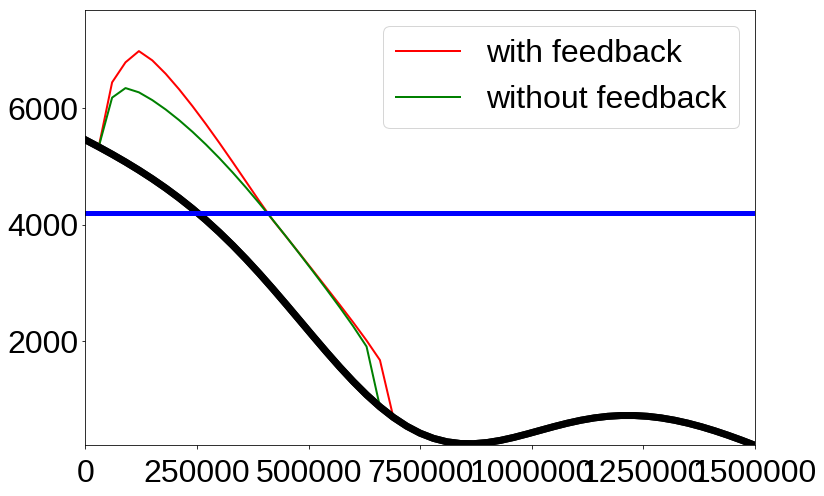

In [148]:
i = 0
E = E_list[i]
h_T = solve_implicit_mb_T(b,L,time_end,dt,E,e)
lT_list[i] = ice_sheet_size(h)
h = solve_implicit_mb(b,L,time_end,dt,E,e)
l_list[i] = ice_sheet_size(h)

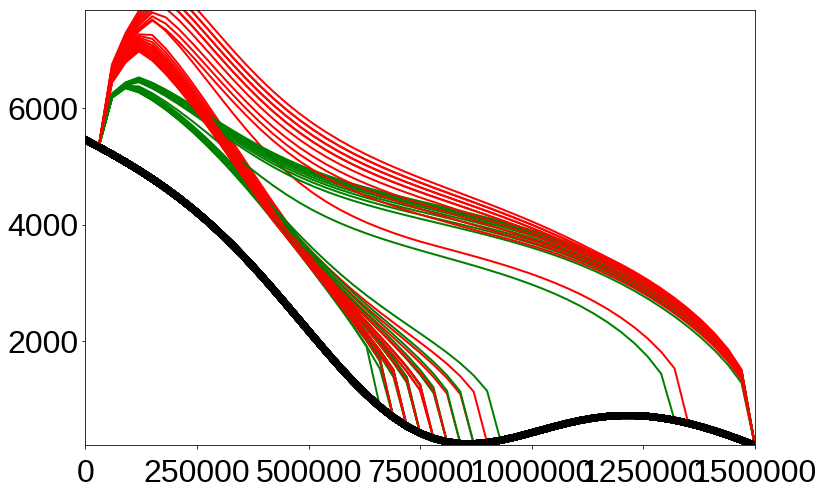

In [149]:
dt = 3
for i in range(len(E_list)):
    E = E_list[i]
    h_new = solve_implicit_mb(b,L,time_end,dt,E,e,plot_time=0,h_init=h,plot_E=False,legend=False)
    h = h_new
    l_list[i] = ice_sheet_size(h)
    hT_new = solve_implicit_mb_T(b,L,time_end,dt,E,e,plot_time=0,h_init=h,plot_E=False,legend=False)
    hT = hT_new
    lT_list[i] = ice_sheet_size(hT)

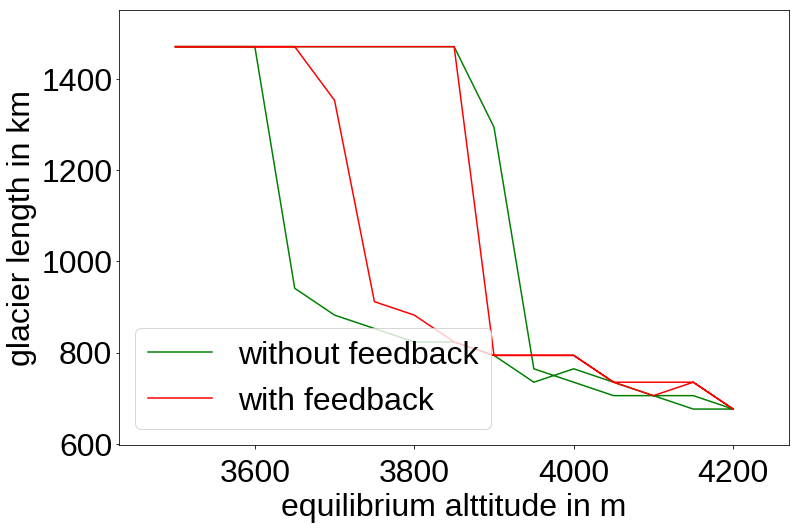

In [151]:
plt.plot(E_list,l_list*1e-3, color="green", label="without feedback")
plt.plot(E_list,lT_list*1e-3, color="red", label="with feedback")
plt.xlabel("equilibrium alttitude in m")
plt.ylabel("glacier length in km")
plt.legend(loc="lower left")